## Sprawozdanie Laboratoria 5

In [153]:
import numpy as np
import pandas as pd
from scipy.linalg import hilbert, solve_triangular
import math
import time 
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import bicg, gmres

### Zadanie 1

In [10]:
a = np.array([[1, 1],[1, 1.0001]])
print("Współczynnik uwarunkowania A: ", end=' ')
print(np.linalg.cond(a))
a_inv = np.linalg.inv(a)
b1 = np.array([[2],[2.0001]])
b2 = np.array([[2],[2]])
x1 = np.dot(a_inv,b1)
x2 = np.dot(a_inv,b2)
print()
print(x1, x2, sep='\n\n')

Współczynnik uwarunkowania A:  40002.000074915224

[[1.]
 [1.]]

[[2.]
 [0.]]


#### Dla niewielkiej zmiany wektora prawych stron diametralnie zmieniło się rozwiązanie. Wynika to z dużego współczynnika uwarunkowania macierzy A.

### Zadanie 2

In [29]:
hilb = hilbert(8)
print("Norma spektralna: {}".format(np.linalg.cond(hilb)))
print("Norma kolumnowa: {}".format(np.linalg.cond(hilb, 1)))
print("Norma wierszowa: {}".format(np.linalg.cond(hilb, np.inf)))

Norma spektralna: 15257575566.627958
Norma kolumnowa: 33872789110.107353
Norma wierszowa: 33872789109.75766


#### Na podstawie tych norm możemy stwierdzić, że macierz Hilberta jest źle uwarunkowana

### Zadanie 3

In [35]:
n = 20
t = np.transpose(np.random.random_sample((20,)))
b = np.transpose([[math.cos(4*t[i]) for i in range(len(t))]])
vand = np.vander(t, increasing=True)
#npd = pd.DataFrame(vand)

x1 = np.linalg.solve(vand, b) #metoda solve

Q, R = np.linalg.qr(vand)
x2 = solve_triangular(R, np.dot(np.transpose(Q), b)) #rozkład QR

x3 = np.linalg.lstsq(vand, b, rcond=None) #lstsq

time_ = time.time()
for x in range(20000):
    np.linalg.solve(vand, b)
print("Metoda Solve - czas: {} norma: {}".format(time.time()-time_ , np.linalg.norm(np.subtract(b, np.dot(vand, x1)))))

time_ = time.time()
for x in range(20000):
    Q, R = np.linalg.qr(vand)
    solve_triangular(R, np.dot(np.transpose(Q), b))
print("Metoda QR - czas: {} norma: {}".format(time.time()-time_, np.linalg.norm(np.subtract(b, np.dot(vand, x2)))))

time_ = time.time()
for x in range(20000):
    np.linalg.lstsq(vand, b, rcond=None)
print("Metoda domyślna - czas: {} norma: {}".format(time.time()-time_, np.linalg.norm(np.subtract(b, np.dot(vand, x2)))))

Metoda Solve - czas: 0.25833725929260254 norma: 1.3506799731660484e-13
Metoda QR - czas: 2.0009734630584717 norma: 2.6433839048260625e-15
Metoda domyślna - czas: 1.4856278896331787 norma: 2.6433839048260625e-15


#### Najszybsza w działaniu jest metoda solve z pakietu numpy, wolniejsza metoda lstsq a najwolniejszy okazał się rozkład QR
#### Normy wszystkich metod są podobne i bliskie 0

### Zadanie 4

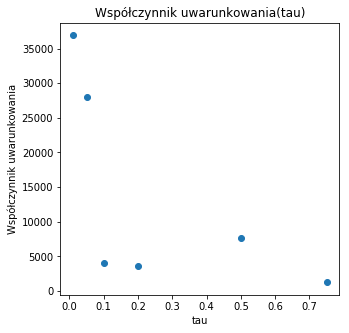

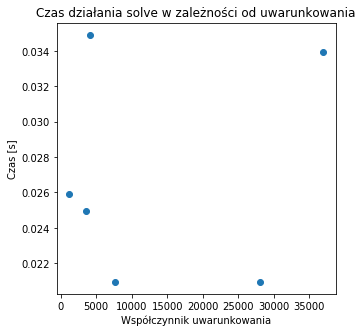

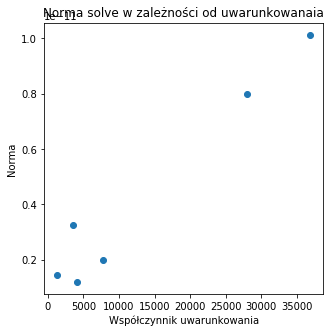

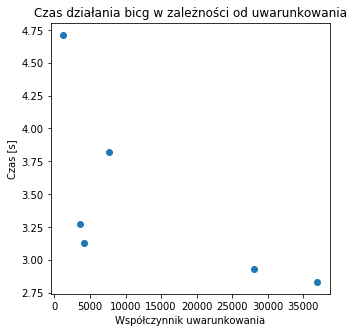

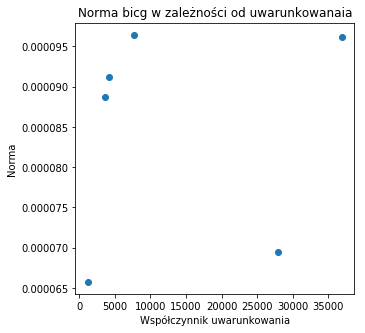

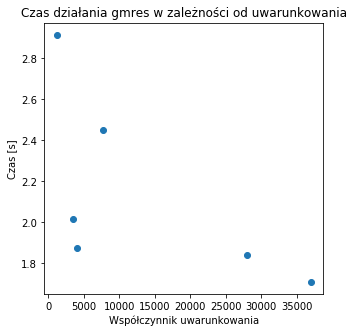

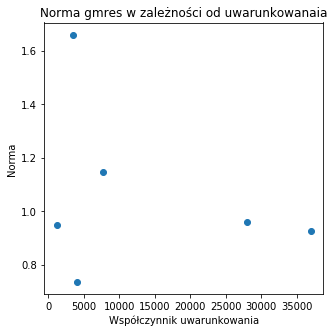

In [94]:
diag = np.diag(np.ones(500))
triang = np.tril(np.random.uniform(-1,1,[500,500]), -1)

A = np.add(triang, (np.add(np.transpose(triang), diag)))
b = np.transpose(np.random.uniform(-1,1,[500]))

tau = [0.01, 0.05, 0.1, 0.2, 0.5, 0.75]

# test = pd.DataFrame(A)
# test.head()

conds = []

norms_solve = []
times_solve = []

norms_bicg = []
times_bicg = []

norms_gmres = []
times_gmres = []


for t in tau:
    A_temp = A.copy()
    l = len(A_temp)
    for i in range(l):
        for j in range(l):
            if(i != j and abs(A_temp[i][j] > t)):
                A_temp[i][j] = 0  
                
    conds.append(np.linalg.cond(A_temp))
    
    time_ = time.time()
    for x in range(10):
        x_solve = np.linalg.solve(A_temp, b)
    times_solve.append(time.time() - time_)
    norms_solve.append(np.linalg.norm(np.subtract(b, np.dot(A_temp, x_solve))))
    
    A_csr = csr_matrix(A_temp)
    time_ = time.time()
    for x in range(10):
        x_solve = bicg(A_csr, b)
    times_bicg.append(time.time() - time_)
    norms_bicg.append(np.linalg.norm(np.subtract(b, np.dot(A_temp, x_solve[0]))))
    
    time_ = time.time()
    for x in range(10):
        x_solve = gmres(A_csr, b, maxiter=50)
    times_gmres.append(time.time() - time_)
    norms_gmres.append(np.linalg.norm(np.subtract(b, np.dot(A_temp, x_solve[0]))))
    
plt.figure(figsize=[5, 5])      
plt.plot(tau, conds, 'o')
plt.title("Współczynnik uwarunkowania(tau)")
plt.xlabel("tau")
plt.ylabel("Współczynnik uwarunkowania")

plt.figure(figsize=[5, 5])
plt.plot(conds, times_solve, 'o')
plt.title("Czas działania solve w zależności od uwarunkowania")
plt.xlabel("Współczynnik uwarunkowania")
plt.ylabel("Czas [s]")
plt.figure(figsize=[5, 5])
plt.plot(conds, norms_solve, 'o')
plt.title("Norma solve w zależności od uwarunkowanaia")
plt.xlabel("Współczynnik uwarunkowania")
plt.ylabel("Norma")

plt.figure(figsize=[5, 5])
plt.plot(conds, times_bicg, 'o')
plt.title("Czas działania bicg w zależności od uwarunkowania")
plt.xlabel("Współczynnik uwarunkowania")
plt.ylabel("Czas [s]")
plt.figure(figsize=[5, 5])
plt.plot(conds, norms_bicg, 'o')
plt.title("Norma bicg w zależności od uwarunkowanaia")
plt.xlabel("Współczynnik uwarunkowania")
plt.ylabel("Norma")

plt.figure(figsize=[5, 5])
plt.plot(conds, times_gmres, 'o')
plt.title("Czas działania gmres w zależności od uwarunkowania")
plt.xlabel("Współczynnik uwarunkowania")
plt.ylabel("Czas [s]")
plt.figure(figsize=[5, 5])
plt.plot(conds, norms_gmres, 'o')
plt.title("Norma gmres w zależności od uwarunkowanaia")
plt.xlabel("Współczynnik uwarunkowania")
plt.ylabel("Norma")

plt.show()

### Zadanie 5

In [168]:
def gauss_seidel(A, b, n, epsilon):
    LD = np.tril(A)
    U = np.subtract(A, LD)
    Mgs = np.dot(-(np.linalg.inv(LD)), U)
    spectral_radius = max(abs(np.linalg.eigvals(Mgs)))
    #warunek zbieżności - promień spektralny mniejszy od 1
    if(spectral_radius < 1):
        x_k = np.zeros(n)
        x_k1 = np.zeros(n)
        while(True):
            for i in range(n):
                x_k1[i] = (-1/A[i][i])*(sum([A[i][j]*x_k1[j] for j in range(i)]) + sum([A[i][j]*x_k[j] for j in range(i+1, n)])) + (b[i]/A[i][i])
            if(np.linalg.norm(x_k1-x_k, np.inf) < epsilon):
                return x_k1
            else:
                x_k = x_k1.copy()
    else:
        return "Warunek zbieżności nie spełniony - promień spektralny macierzy >= 1"
        
A = np.array([[8, 15, -7],
       [5, 21, 2],
       [4, -5, 15]])
b = np.array([22, 13, 3])
print(gauss_seidel(A,b,3,0.0001))
print(np.linalg.solve(A, b))

A = np.array([[1, 2, 3],
       [2, 1, 3],
       [3, 2, 1]])
b = np.array([1, 2, 0])
print(gauss_seidel(A, b, 3, 0.0001))

[ 2.20991401  0.12595781 -0.34732447]
[ 2.20992366  0.1259542  -0.34732824]
Warunek zbieżności nie spełniony - promień spektralny macierzy >= 1


#### Warunek zbieżności nie jest spełniony więc nie możemy zastosować dla tej macierzy metody Gaussa-Seidla a tym samym nie możemy ocenić jakości rozwiązania